In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
    
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxesBlazeFace import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_encoder_decoder.ssd_input_encoder_blazeface import SSDInputEncoder

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize

%matplotlib inline

Using TensorFlow backend.
/workspace/blazeface_keras/data_generator/object_detection_2d_data_generator.py:44: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


In [3]:
# Set the image size.
img_height = 256
img_width = 256

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.
select_keypoint = [9,11,13,14,21,23,24,25,26]
output_index = []
for i in select_keypoint:
    output_index.append(i*2-2)
    output_index.append(i*2-1)
model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='training',
                normalize_coords=True,
                subtract_mean=[107, 105, 109],
                swap_channels=[2, 1, 0],
                feature=len(output_index))

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/new_anchor_256_fix_DBset_2_epoch-94_loss-0.2177.h5'

# model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0, select_keypoint_labels_len=len(output_index))

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 256, 256, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 256, 256, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

In [6]:
train_images_dir = "/data/"
train_labels_filename = "/data/tsmoon_set/train_setting_2.csv"

train_dataset = DataGenerator(load_images_into_memory=None, hdf5_dataset_path=None,fix_image_ratio=True)


train_dataset.parse_csv(images_dir=train_images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name','xmin','ymin','xmax', 'ymax', 'kp1_x','kp1_y','kp2_x','kp2_y','kp3_x','kp3_y','kp4_x','kp4_y','kp5_x','kp5_y',
                                           'kp6_x','kp6_y','kp7_x','kp7_y','kp8_x','kp8_y','kp9_x','kp9_y','kp10_x','kp10_y','kp11_x','kp11_y','kp12_x','kp12_y','kp13_x',
                                           'kp13_y','kp14_x','kp14_y','kp15_x','kp15_y','kp16_x','kp16_y','kp17_x','kp17_y','kp18_x','kp18_y','kp19_x','kp19_y','kp20_x','kp20_y','kp21_x',
                                           'kp21_y','kp22_x','kp22_y','kp23_x','kp23_y','kp24_x','kp24_y','kp25_x','kp25_y','kp26_x','kp26_y','class_id'],
                        include_classes='all')

In [8]:
batch_size = 32
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
normalize_coords = True
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color,
                                            random_crop_prob=0.5,
                                            rotate_prob=0.4)
convert_to_3_channels = ConvertTo3Channels()

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                        shuffle=True,
                                        transformations=[ssd_data_augmentation],
                                        label_encoder=ssd_input_encoder,
                                        select_keypoint_label=output_index,
                                        returns={'processed_images',
                                                'encoded_labels',
                                                'filenames'},
                                        keep_images_without_gt=normalize_coords)

In [45]:
a = next(train_generator)

In [46]:
print("model output shape :", a[1].shape)
print("input image shape : ", a[0].shape)
print("data file name : ", a[2][1])

model output shape : (32, 1, 36)
input image shape :  (32, 256, 256, 3)
data file name :  /data/Korea_Female_2/20200907_night_light_01/Class_4/frame/3_20200907_night_light_01/3_20200907_night_light_01_18 04.jpg


In [47]:
confidence_thresh=0.01
iou_threshold=0.45
nms_max_output_size=400
normalize_coords=True
coords='centroids'
top_k = 200

decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   select_keypoint_label=output_index,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')


In [48]:
y_pred = tf.convert_to_tensor(a[1])
y_pred = tf.cast(y_pred,tf.float32)
output = decoded_predictions.call(y_pred)

In [49]:
output[0][0].numpy()

array([ 10.56,  11.11,   9.27,  11.47,  11.04,   8.99,  11.83,  11.76,
        16.21, -21.04,  15.7 , -24.03,  16.29, -22.23,  17.89, -27.35,
        17.22, -28.91], dtype=float32)

In [50]:
anchor = np.array([ float(x) for x in open('anchor_256_fix.txt').readline().split(',') if x != ''])
anchor = anchor[output_index]
anchor

array([ 89.44,  98.89, 116.73,  98.53, 103.96,  94.01, 104.17, 102.24,
       118.79, 180.04, 148.3 , 167.03, 147.71, 174.23, 147.11, 179.35,
       147.78, 188.91])

In [51]:
box = np.add(output[0][0].numpy(), anchor).astype(int)

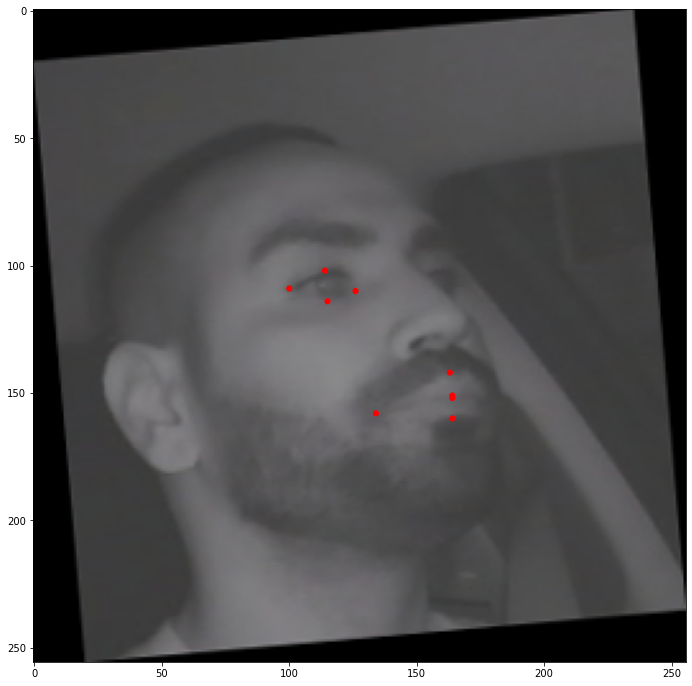

In [52]:
# Display the image and draw the predicted boxes onto it.
from PIL import Image
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'face']

plt.figure(figsize=(20,12))


plt.imshow(Image.fromarray(a[0][0]))

current_axis = plt.gca()


for i in range(0, len(box), 2):
    current_axis.add_patch(plt.Circle((box[i], box[i+1]), 1, color=color[0]))
    